In [1]:
import sys 

pathScripts = '../COMPAS/utils/CosmicIntegration' 

sys.path.append(pathScripts) 

In [2]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib import rc
import astropy.units as u
from astropy import constants as const
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton
import warnings
import time

from scipy.stats.kde import gaussian_kde
from numpy import linspace

import h5py as h5 

import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

In [3]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [4]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
hobbs_pathData        = os.environ['SCRATCH']+f'/supernova_remnant_merger_rates/hobbs_2e7_combined.h5'
mm_pathData        = os.environ['SCRATCH'] + f"/supernova_remnant_merger_rates/mm20_520_2e7_combined.h5"

In [6]:
fdata = h5.File(hobbs_pathData, 'r')

SN_STELLAR_TYPE = fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
UNBOUND  = fdata['BSE_Supernovae']["Unbound"][...].squeeze() 
# SN_KICK = fdata['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
SN_KICK = fdata['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()

SEED = fdata['BSE_System_Parameters']["SEED"][...].squeeze() 
unique, counts = np.unique(SEED, return_counts=True)
print(len(SEED))
print(len(unique))

# Select single NS with additional ECSN H-poor constraint
maskSN_NS = ((SN_STELLAR_TYPE ==13) * (UNBOUND == 1)) 

fdata.close()

SN_KICK_NS_HOBBS = SN_KICK[maskSN_NS]  

20000064
20000064


In [7]:
fdata = h5.File(mm_pathData, 'r')

SN_STELLAR_TYPE = fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
SN_TYPE = fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
UNBOUND  = fdata['BSE_Supernovae']["Unbound"][...].squeeze() 
# SN_KICK = fdata['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()
SN_KICK = fdata['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()

SEED = fdata['BSE_Supernovae']["SEED"][...].squeeze() 
unique, indices = np.unique(SEED, return_index=True)
print(len(SEED))
print(len(unique))

# select only unique SNs
SN_STELLAR_TYPE = fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()[indices]
SN_TYPE = fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze()[indices]
UNBOUND  = fdata['BSE_Supernovae']["Unbound"][...].squeeze()[indices]
# SN_KICK = fdata['BSE_Supernovae']['Applied_Kick_Magnitude(SN)'][...].squeeze()[indices]
SN_KICK = fdata['BSE_Supernovae']['ComponentSpeed(SN)'][...].squeeze()[indices]

print(len(SN_STELLAR_TYPE))

# Select single NS with additional ECSN H-poor constraint
maskSN_NS = ((SN_STELLAR_TYPE ==13) * (UNBOUND == 1)) 

fdata.close()

SN_KICK_NS_MM = SN_KICK[maskSN_NS]  

22752832
8128282
8128282


In [18]:
kde_NS_mm = gaussian_kde( SN_KICK_NS_MM)
NS_dist_space_mm = np.linspace( 0, 1200, 300 )

In [19]:
kde_NS_hobbs = gaussian_kde( SN_KICK_NS_HOBBS )
NS_dist_space_hobbs = np.linspace( 0, 1200, 300 )

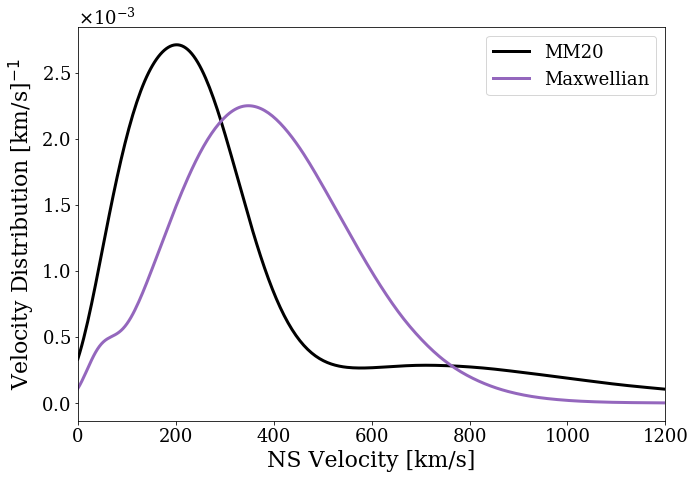

In [68]:
f, ax= plt.subplots(1, 1,  figsize=(10,7)) 

lw = 3

label_str = r'MM20'

plt.plot( NS_dist_space_mm, kde_NS_mm(NS_dist_space_mm), 'k', lw=lw, label=label_str)
plt.plot( NS_dist_space_hobbs, kde_NS_hobbs(NS_dist_space_hobbs), 'tab:purple', lw=lw, label='Maxwellian')

plt.rc('font', size=fm)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

plt.xlabel('NS Velocity [km/s]', fontsize=fl)
plt.ylabel('Velocity Distribution [km/s]$^{-1}$', fontsize=fl)

plt.xlim(0, 1200)

plt.legend(fontsize=fm)
plt.tight_layout()
# plt.savefig('plots/hobbs_vs_best.pdf')
plt.show()


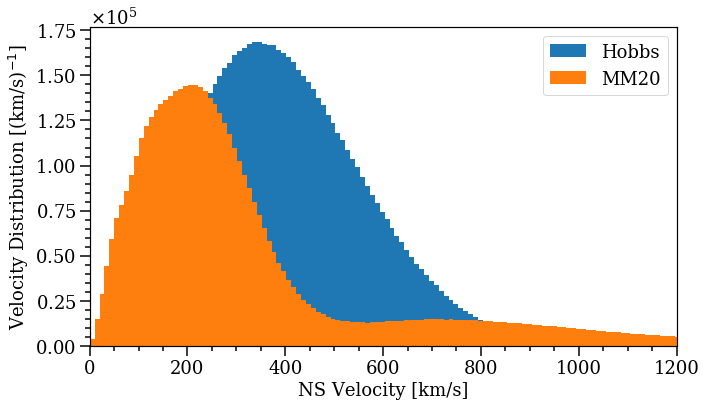

In [21]:
plt.rc('font', size=fm)
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

lw = 3
alpha=1

bins = np.linspace(0, 2000, 200)

plt.hist(SN_KICK_NS_HOBBS, bins=bins, label='Hobbs')
plt.hist(SN_KICK_NS_MM, bins=bins, label='MM20')

layoutAxes(ax=ax, nameX='NS Velocity [km/s]',\
       nameY='Velocity Distribution [(km/s)$^{-1}$]')

plt.rc('font', size=fm)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

plt.xlim(0, 1200)

plt.legend(fontsize=fm)
plt.tight_layout()
plt.show()

In [8]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BHBH, BHNS, BNS
# dco_type        = "all"

weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O3" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 0.1 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

# Hobbs

## BHNS

In [23]:
# dco_type        = "BHNS"

# hobbs_bhns_detection_rate, hobbs_bhns_formation_rate, hobbs_bhns_merger_rate, hobbs_bhns_redshifts, hobbs_bhns_COMPAS = FCI.find_detection_rate(
#     hobbs_pathData, dco_type=dco_type, weight_column=weight_column,
#     merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
#     no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
#     max_redshift_detection=max_redshift_detection,
#     redshift_step=redshift_step, z_first_SF=z_first_SF,
#     m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
#     fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
#     mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
#     min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
#     sensitivity=sensitivity, snr_threshold=snr_threshold,
#     Mc_max=Mc_max, Mc_step=Mc_step,
#     eta_max=eta_max, eta_step=eta_step,
#     snr_max=snr_max, snr_step=snr_step)

In [24]:
# hobbs_bhns_chirp_masses = (hobbs_bhns_COMPAS.mass1*hobbs_bhns_COMPAS.mass2)**(3./5.) / (hobbs_bhns_COMPAS.mass1 + hobbs_bhns_COMPAS.mass2)**(1./5.)

# # sum things up across binaries
# hobbs_bhns_total_formation_rate = np.sum(hobbs_bhns_formation_rate, axis=0)
# hobbs_bhns_total_merger_rate = np.sum(hobbs_bhns_merger_rate, axis=0)
# hobbs_bhns_merger_rate_by_binary = np.sum(hobbs_bhns_merger_rate, axis=1)
# hobbs_bhns_total_detection_rate = np.sum(hobbs_bhns_detection_rate, axis=0)

# # and across redshifts
# hobbs_bhns_cumulative_detection_rate = np.cumsum(hobbs_bhns_total_detection_rate)
# hobbs_bhns_detection_rate_by_binary = np.sum(hobbs_bhns_detection_rate, axis=1)

## BNS

In [9]:
dco_type   =   "BNS"

hobbs_bns_detection_rate, hobbs_bns_formation_rate, hobbs_bns_merger_rate, hobbs_bns_redshifts, hobbs_bns_COMPAS = FCI.find_detection_rate(
    hobbs_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  app.launch_new_instance()


Average_SF_mass_needed =  2024336123.311944 solMass


In [10]:
hobbs_bns_chirp_masses = (hobbs_bns_COMPAS.mass1*hobbs_bns_COMPAS.mass2)**(3./5.) / (hobbs_bns_COMPAS.mass1 + hobbs_bns_COMPAS.mass2)**(1./5.)

# sum things up across binaries
hobbs_bns_total_formation_rate = np.sum(hobbs_bns_formation_rate, axis=0)
hobbs_bns_total_merger_rate = np.sum(hobbs_bns_merger_rate, axis=0)
hobbs_bns_merger_rate_by_binary = np.sum(hobbs_bns_merger_rate, axis=1)
hobbs_bns_total_detection_rate = np.sum(hobbs_bns_detection_rate, axis=0)

# and across redshifts
hobbs_bns_cumulative_detection_rate = np.cumsum(hobbs_bns_total_detection_rate)
hobbs_bns_detection_rate_by_binary = np.sum(hobbs_bns_detection_rate, axis=1)

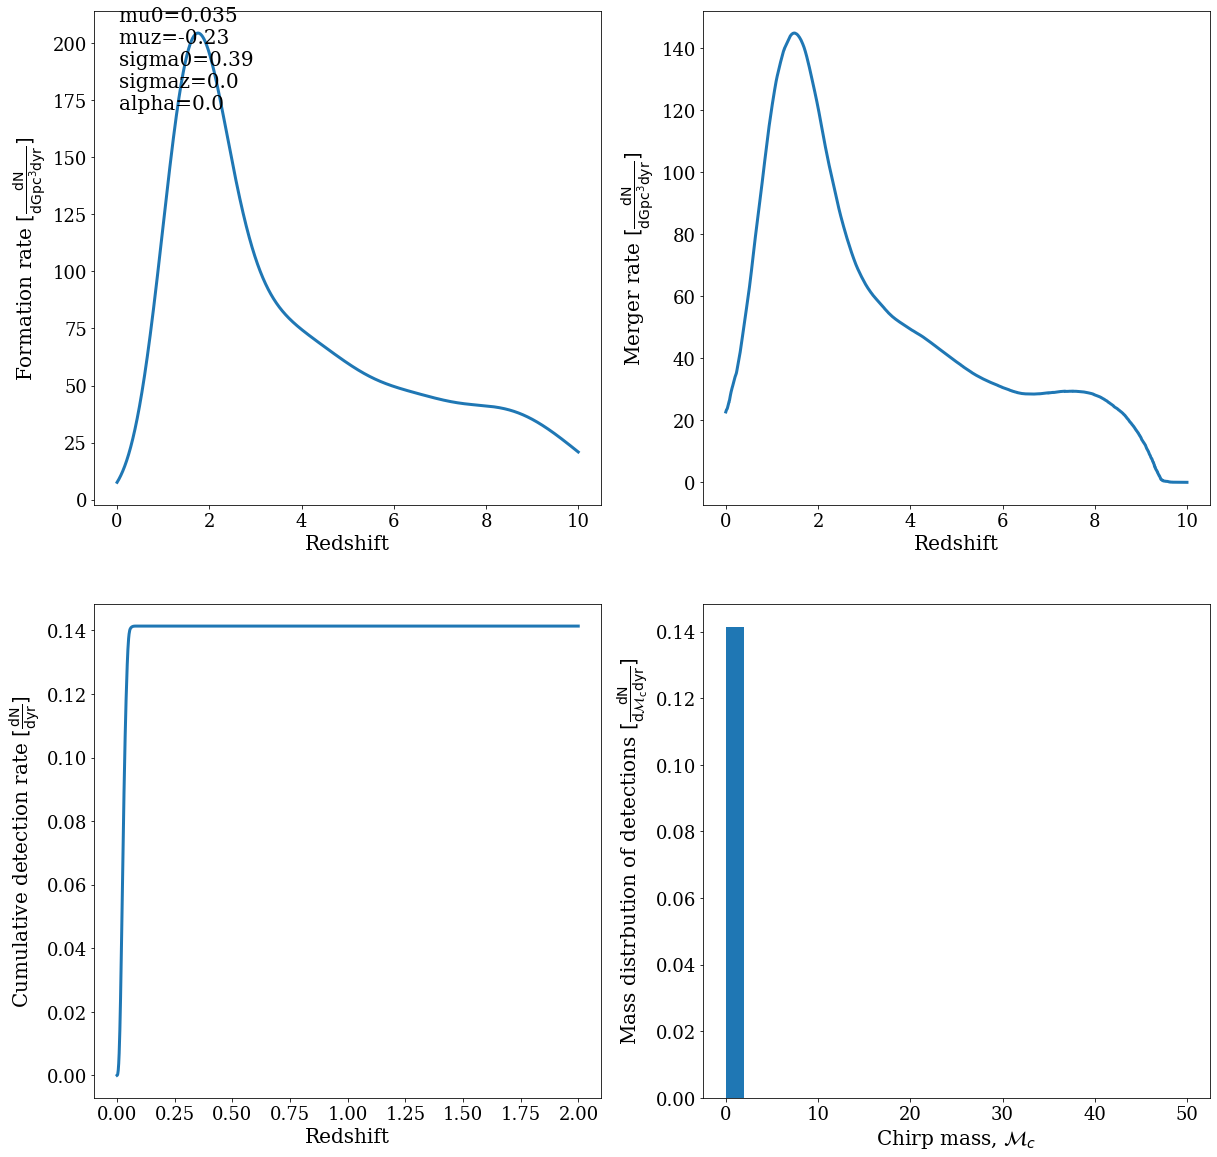

In [11]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(hobbs_bns_redshifts, hobbs_bns_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(hobbs_bns_redshifts, hobbs_bns_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(hobbs_bns_redshifts[:len(hobbs_bns_cumulative_detection_rate)], hobbs_bns_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(hobbs_bns_chirp_masses, weights=hobbs_bns_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 


# MullerMandel

## BHNS

In [12]:
# dco_type = "BHNS"

# mm_bhns_detection_rate, mm_bhns_formation_rate, mm_bhns_merger_rate, mm_bhns_redshifts, mm_bhns_COMPAS = FCI.find_detection_rate(
#     mm_pathData, dco_type=dco_type, weight_column=weight_column,
#     merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
#     no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
#     max_redshift_detection=max_redshift_detection,
#     redshift_step=redshift_step, z_first_SF=z_first_SF,
#     m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
#     fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
#     mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
#     min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
#     sensitivity=sensitivity, snr_threshold=snr_threshold,
#     Mc_max=Mc_max, Mc_step=Mc_step,
#     eta_max=eta_max, eta_step=eta_step,
#     snr_max=snr_max, snr_step=snr_step)


In [13]:
# mm_bhns_chirp_masses = (mm_bhns_COMPAS.mass1*mm_bhns_COMPAS.mass2)**(3./5.) / (mm_bhns_COMPAS.mass1 + mm_bhns_COMPAS.mass2)**(1./5.)

# # sum things up across binaries
# mm_bhns_total_formation_rate = np.sum(mm_bhns_formation_rate, axis=0)
# mm_bhns_total_merger_rate = np.sum(mm_bhns_merger_rate, axis=0)
# mm_bhns_merger_rate_by_binary = np.sum(mm_bhns_merger_rate, axis=1)
# mm_bhns_total_detection_rate = np.sum(mm_bhns_detection_rate, axis=0)

# # and across redshifts
# mm_bhns_cumulative_detection_rate = np.cumsum(mm_bhns_total_detection_rate)
# mm_bhns_detection_rate_by_binary = np.sum(mm_bhns_detection_rate, axis=1)

## BNS

In [14]:
dco_type = "BNS"

mm_bns_detection_rate, mm_bns_formation_rate, mm_bns_merger_rate, mm_bns_redshifts, mm_bns_COMPAS = FCI.find_detection_rate(
    mm_pathData, dco_type=dco_type, weight_column=weight_column,
    merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
    no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
    max_redshift_detection=max_redshift_detection,
    redshift_step=redshift_step, z_first_SF=z_first_SF,
    m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
    fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
    mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
    min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
    sensitivity=sensitivity, snr_threshold=snr_threshold,
    Mc_max=Mc_max, Mc_step=Mc_step,
    eta_max=eta_max, eta_step=eta_step,
    snr_max=snr_max, snr_step=snr_step)


/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  app.launch_new_instance()


Average_SF_mass_needed =  4070725313.960725 solMass


In [15]:
mm_bns_chirp_masses = (mm_bns_COMPAS.mass1*mm_bns_COMPAS.mass2)**(3./5.) / (mm_bns_COMPAS.mass1 + mm_bns_COMPAS.mass2)**(1./5.)

# sum things up across binaries
mm_bns_total_formation_rate = np.sum(mm_bns_formation_rate, axis=0)
mm_bns_total_merger_rate = np.sum(mm_bns_merger_rate, axis=0)
mm_bns_merger_rate_by_binary = np.sum(mm_bns_merger_rate, axis=1)
mm_bns_total_detection_rate = np.sum(mm_bns_detection_rate, axis=0)

# and across redshifts
mm_bns_cumulative_detection_rate = np.cumsum(mm_bns_total_detection_rate)
mm_bns_detection_rate_by_binary = np.sum(mm_bns_detection_rate, axis=1)


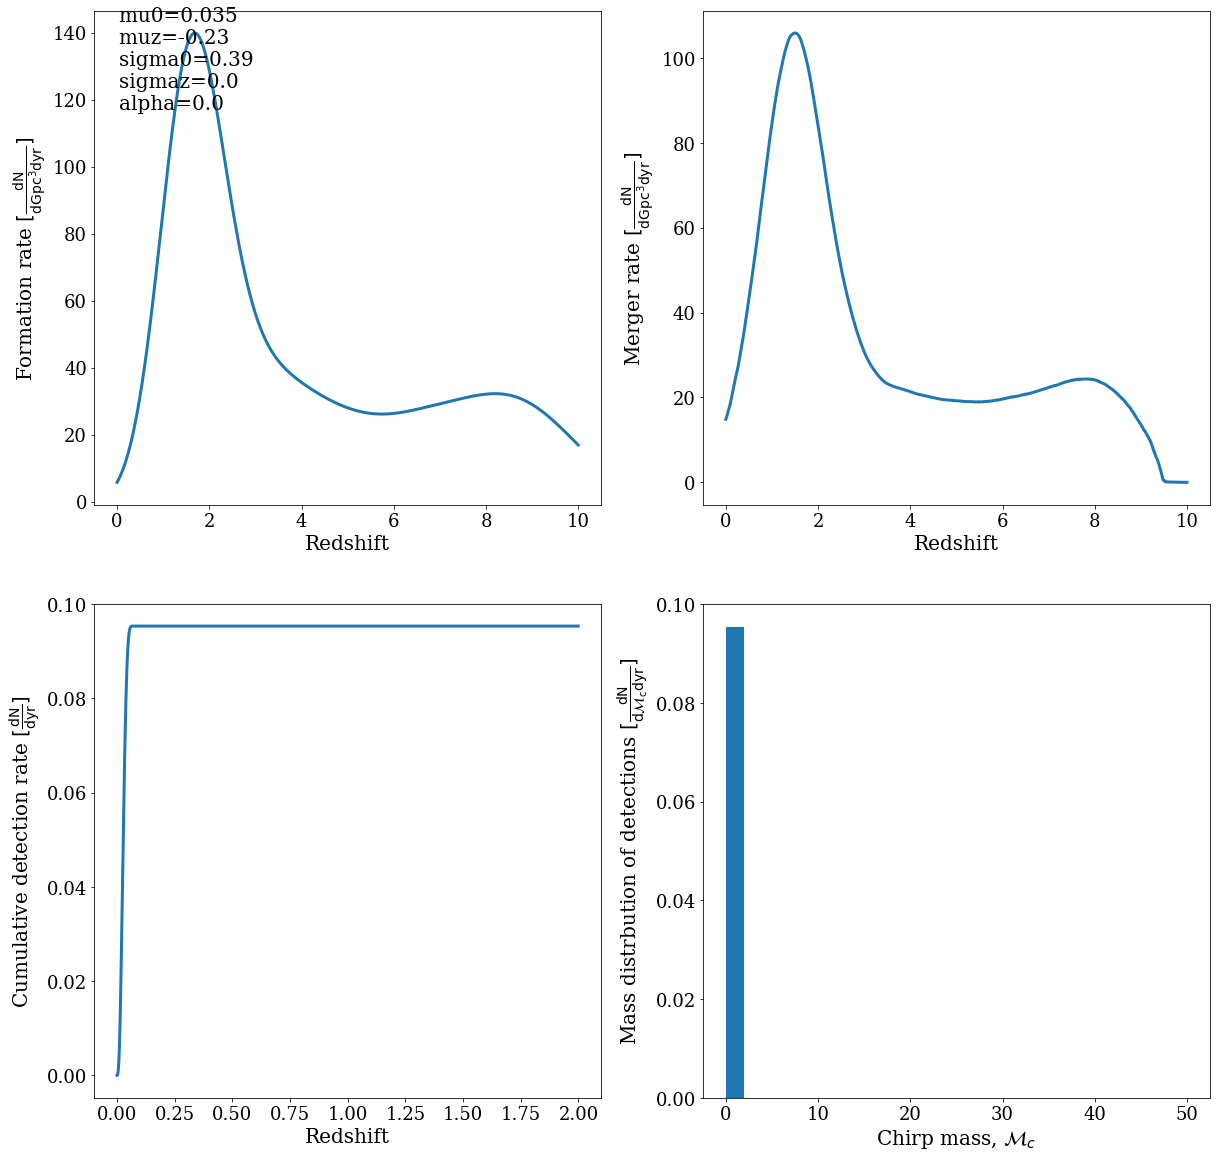

In [16]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

axes[0,0].plot(mm_bns_redshifts, mm_bns_total_formation_rate, lw=lw)
axes[0,0].set_xlabel('Redshift', fontsize=fs)
axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[0,1].plot(mm_bns_redshifts, mm_bns_total_merger_rate, lw=lw)
axes[0,1].set_xlabel('Redshift', fontsize=fs)
axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

axes[1,0].plot(mm_bns_redshifts[:len(mm_bns_cumulative_detection_rate)], mm_bns_cumulative_detection_rate, lw=lw)
axes[1,0].set_xlabel('Redshift', fontsize=fs)
axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

axes[1,1].hist(mm_bns_chirp_masses, weights=mm_bns_detection_rate_by_binary, bins=25, range=(0, 50))
axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

#########################
#Plotvalues

# Add text upper left corner
axes[0,0].text(0.05,0.8, 
        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
        transform=axes[0,0].transAxes, size = fs) 

for ax in axes.flatten():
    ax.tick_params(labelsize=0.9*fs)

# Save and show :)
# plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 
            

# Some Useful Info

In [17]:
# print(f"Hobbs Local BHNS Merger Rate: {hobbs_bhns_total_merger_rate[0]:.2f} / yr/ cubic Gpc")
# print(f"MULLERMANDEL Local BHNS Merger Rate: {mm_bhns_total_merger_rate[0]:.2f} / yr / cubic Gpc")

In [18]:
# print("Number of BHNS mergers in Hobbs :", len(hobbs_bhns_chirp_masses))
# print("Number of BHNS mergers in MULLERMANDEL:", len(mm_bhns_chirp_masses))

In [19]:
print(f"Hobbs Local BNS Merger Rate: {hobbs_bns_total_merger_rate[0]:.2f} / yr/ cubic Gpc")
print(f"MULLERMANDEL Local BNS Merger Rate: {mm_bns_total_merger_rate[0]:.2f} / yr / cubic Gpc")

Hobbs Local BNS Merger Rate: 22.67 / yr/ cubic Gpc
MULLERMANDEL Local BNS Merger Rate: 14.87 / yr / cubic Gpc


In [20]:
print("Number of BNS mergers in Hobbs :", len(hobbs_bns_chirp_masses))
print("Number of BNS mergers in MULLERMANDEL:", len(mm_bns_chirp_masses))

Number of BNS mergers in Hobbs : 3344
Number of BNS mergers in MULLERMANDEL: 4538


In [21]:
print(f"Hobbs Local BNS Detection Rate: {np.sum(hobbs_bns_detection_rate_by_binary):.2e} / yr/ cubic Gpc")
print(f"MULLERMANDEL Local BNS Detection Rate: {np.sum(mm_bns_detection_rate_by_binary):.2e} / yr / cubic Gpc")

Hobbs Local BNS Detection Rate: 1.41e-01 / yr/ cubic Gpc
MULLERMANDEL Local BNS Detection Rate: 9.54e-02 / yr / cubic Gpc


# Get error bars

In [22]:
# get error bars via bootstrapping

In [23]:
def bootstrap_rate(merger_rate, n_boot = None):
    if n_boot is None:
        n_boot = merger_rate.shape[0]
        
    indices = np.random.randint(merger_rate.shape[0], size=n_boot)
    bootstrapped_merger_rate = merger_rate[indices]
    boot_total_merger_rate = np.sum(bootstrapped_merger_rate, axis=0)

    return boot_total_merger_rate[0] # return only local merger rate

## Hobbs

In [50]:
n_samples = 500
hobbs_local_bns_mergers = np.zeros(n_samples)

start = time.time()

for i in range(n_samples):
    hobbs_local_bns_mergers[i] = bootstrap_rate(hobbs_bns_merger_rate)
    
end = time.time()
print(f"Bootstrapping completed in {end-start:.2f} s")

Bootstrapping completed in 54.53 s


In [42]:
# n_samples = 100
# hobbs_local_bhns_mergers = np.zeros(n_samples)

# start = time.time()

# for i in range(n_samples):
#     hobbs_local_bhns_mergers[i] = bootstrap_rate(hobbs_bhns_merger_rate)
    
# end = time.time()
# print(f"Bootstrapping completed in {end-start:.2f} s")

In [52]:
# mean = np.average(hobbs_local_bns_mergers)
mean = hobbs_bns_total_merger_rate[0]
err = 2*np.std(hobbs_local_bns_mergers)
print(f"HOBBS Local BNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

HOBBS Local BNS Merger Rate: 22.59 ± 2.83 / yr/ cubic Gpc


In [44]:
# mean = np.average(hobbs_local_bhns_mergers)
# err = 2*np.std(hobbs_local_bhns_mergers)
# print(f"HOBBS Local BHNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

## MULLERMANDEL

In [49]:
n_samples = 500
mm_local_bns_mergers = np.zeros(n_samples)

start = time.time()

for i in range(n_samples):
    mm_local_bns_mergers[i] = bootstrap_rate(mm_bns_merger_rate)
    
end = time.time()
print(f"Bootstrapping completed in {end-start:.2f} s")

Bootstrapping completed in 74.63 s


In [46]:
# n_samples = 100
# mm_local_bhns_mergers = np.zeros(n_samples)

# start = time.time()

# for i in range(n_samples):
#     mm_local_bhns_mergers[i] = bootstrap_rate(mm_bhns_merger_rate)
    
# end = time.time()
# print(f"Bootstrapping completed in {end-start:.2f} s")

In [51]:
# mean = np.average(mm_local_bns_mergers)
mean = mm_bns_total_merger_rate[0]
err = 2*np.std(mm_local_bns_mergers)
print(f"MULLERMANDEL Local BNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

MULLERMANDEL Local BNS Merger Rate: 14.89 ± 1.62 / yr/ cubic Gpc


In [53]:
# mean = np.average(mm_local_bhns_mergers)
# err = 2*np.std(mm_local_bhns_mergers)
# print(f"MULLERMANDEL Local BHNS Merger Rate: {mean:.2f} ± {err:.2f} / yr/ cubic Gpc")

# Bootstrap Detection Rate

In [24]:
def bootstrap_det_rate(bns_detection_rate_by_binary, n_boot = None):
    if n_boot is None:
        n_boot = bns_detection_rate_by_binary.shape[0]
        
    indices = np.random.randint(bns_detection_rate_by_binary.shape[0], size=n_boot)
    bootstrapped_dets = bns_detection_rate_by_binary[indices]
    boot_total_det_rate = np.sum(bootstrapped_dets)

    return boot_total_det_rate # return only local merger rate

In [25]:
n_samples = 500
hobbs_local_bns_detections = np.zeros(n_samples)

start = time.time()

for i in range(n_samples):
    hobbs_local_bns_detections[i] = bootstrap_det_rate(hobbs_bns_detection_rate_by_binary)
    
end = time.time()
print(f"Bootstrapping completed in {end-start:.2f} s")

Bootstrapping completed in 0.04 s


In [26]:
n_samples = 500
mm_local_bns_detections = np.zeros(n_samples)

start = time.time()

for i in range(n_samples):
    mm_local_bns_detections[i] = bootstrap_det_rate(mm_bns_detection_rate_by_binary)
    
end = time.time()
print(f"Bootstrapping completed in {end-start:.2f} s")

Bootstrapping completed in 0.05 s


In [27]:
mean = np.sum(hobbs_bns_detection_rate_by_binary)
err = 2*np.std(hobbs_local_bns_detections)
print(f"HOBBS Local BNS Detection Rate: {mean:.3f} ± {err:.3f} / yr/ cubic Gpc")

HOBBS Local BNS Detection Rate: 0.141 ± 0.018 / yr/ cubic Gpc


In [28]:
mean = np.sum(mm_bns_detection_rate_by_binary)
err = 2*np.std(mm_local_bns_detections)
print(f"MULLERMANDEL Local BNS Detection Rate: {mean:.3f} ± {err:.3f} / yr/ cubic Gpc")

MULLERMANDEL Local BNS Detection Rate: 0.095 ± 0.010 / yr/ cubic Gpc


# Period-Eccentricity Distribution

The H5 file contains ALL the DCOs. The COMPAS object only contains the DCOs that merge within hubble time AND are of type type_dco.

To get the eccentricity-period distribution of BNSs, we set dco_type='bns' above, and will select the set of DCOs from the H5 file whose Merges_Hubble_Time==True, Stellar_Type(1)'+ 'Stellar_Type(2)==26.

In [58]:
def mask_type(data, st_type1, st_type2, dco_type='BBH', merge=None):
    masked_data = data
    
    if merge is not None:
        mask_hubble = (merge==True)
        masked_data = masked_data[mask_hubble]
        st_type1 = st_type1[mask_hubble]
        st_type2 = st_type2[mask_hubble]
        
    if dco_type=='BBH':
        st_type_sum = 28
    if dco_type=='BNS':
        st_type_sum = 26
    if dco_type=='BHNS':
        st_type_sum = 27
    if dco_type=='all':
        return masked_data
    
    mask = (st_type1 + st_type2==st_type_sum)
    return masked_data[mask]

In [59]:
# sma in AU
# m1 in M_sun 
# m2 in M_sun
# period in yr

def sma_to_period(sma, m1, m2):
    sma = sma*u.au
    m1 = m1*const.M_sun
    m2 = m2*const.M_sun
    
    return 2*np.pi*np.sqrt((sma**3)/(const.G*(m1+m2))).to(u.yr).value

In [60]:
hobbs_fdata = h5.File(hobbs_pathData, 'r')
hobbs_merge = hobbs_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

hobbs_m1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
hobbs_m2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

hobbs_type1_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
hobbs_type2_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

hobbs_ecc_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
hobbs_sma_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
hobbs_merge_t_ALL = hobbs_fdata['BSE_Double_Compact_Objects']["Coalescence_Time"][()]



hobbs_dco_seeds = hobbs_fdata['BSE_Double_Compact_Objects']["SEED"][()]


hobbs_unbound_ALL = hobbs_fdata['BSE_Supernovae']["Unbound"][()]
hobbs_sn_seeds = hobbs_fdata['BSE_Supernovae']["SEED"][()]

hobbs_fdata.close()

In [61]:
mm_fdata = h5.File(mm_pathData, 'r')
mm_merge = mm_fdata['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][()]

mm_m1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
mm_m2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]

mm_type1_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
mm_type2_ALL = mm_fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

mm_ecc_ALL = mm_fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
mm_sma_ALL = mm_fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
mm_merge_t_ALL = mm_fdata['BSE_Double_Compact_Objects']["Coalescence_Time"][()]

mm_fdata.close()

In [62]:
# dco_type='BHNS'
dco_type='BNS'

In [63]:
hobbs_ecc = mask_type(hobbs_ecc_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_sma = mask_type(hobbs_sma_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_t_merge = mask_type(hobbs_merge_t_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_t = mask_type(hobbs_merge_t_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=None)

hobbs_m1 = mask_type(hobbs_m1_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)
hobbs_m2 = mask_type(hobbs_m2_ALL, hobbs_type1_ALL, hobbs_type2_ALL, dco_type=dco_type, merge=hobbs_merge)

print(len(hobbs_ecc))

hobbs_period = sma_to_period(hobbs_sma, hobbs_m1, hobbs_m2)
print((hobbs_period))

3344
[0.00167441 0.00017198 0.00017671 ... 0.06179007 0.00068385 0.00034996]


In [64]:
mm_ecc = mask_type(mm_ecc_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_sma = mask_type(mm_sma_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_t_merge = mask_type(mm_merge_t_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_t = mask_type(mm_merge_t_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=None)


mm_m1 = mask_type(mm_m1_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)
mm_m2 = mask_type(mm_m2_ALL, mm_type1_ALL, mm_type2_ALL, dco_type=dco_type, merge=mm_merge)

print(len(mm_ecc))

mm_period = sma_to_period(mm_sma, mm_m1, mm_m2)
# print((mm_period))

4538


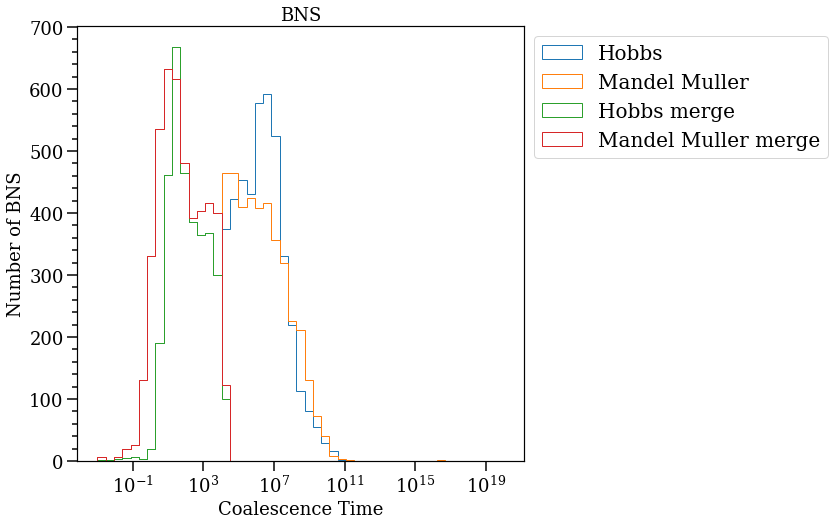

In [65]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10

bins = np.logspace(-3, 20, 50)
layoutAxes(ax=ax, nameX='Coalescence Time',\
           nameY='Number of BNS')

plt.hist(hobbs_t, bins=bins, histtype='step', density=False, label='Hobbs')
plt.hist(mm_t, bins=bins, histtype='step', density=False, label='Mandel Muller')

plt.hist(hobbs_t_merge, bins=bins, histtype='step', density=False, label='Hobbs merge')
plt.hist(mm_t_merge, bins=bins, histtype='step', density=False, label='Mandel Muller merge')

plt.title(f"{dco_type}", fontsize=fm)

lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
plt.semilogx()
# plt.ylim(1e-3, 1e-1)
# plt.xlim(0.4, 0.6)
# plt.grid()
plt.show()

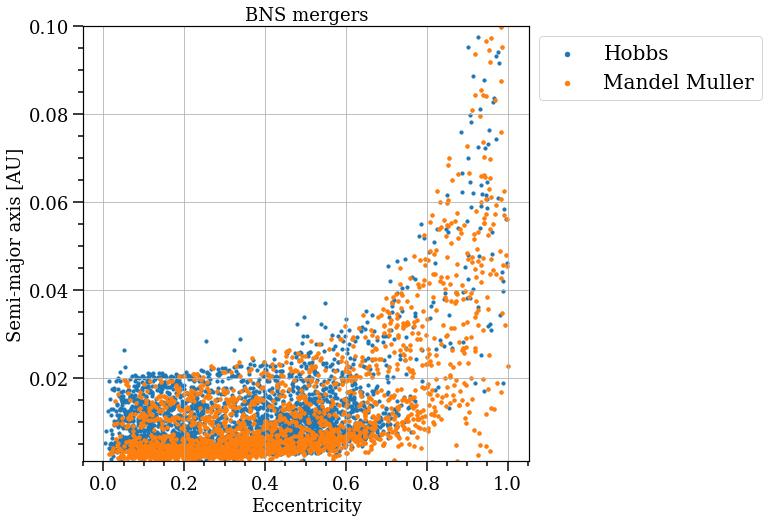

In [66]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Semi-major axis [AU]')

plt.scatter(hobbs_ecc, hobbs_sma, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_sma, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)

lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.semilogy()
plt.ylim(1e-3, 1e-1)
# plt.xlim(0.4, 0.6)
plt.grid()
plt.show()


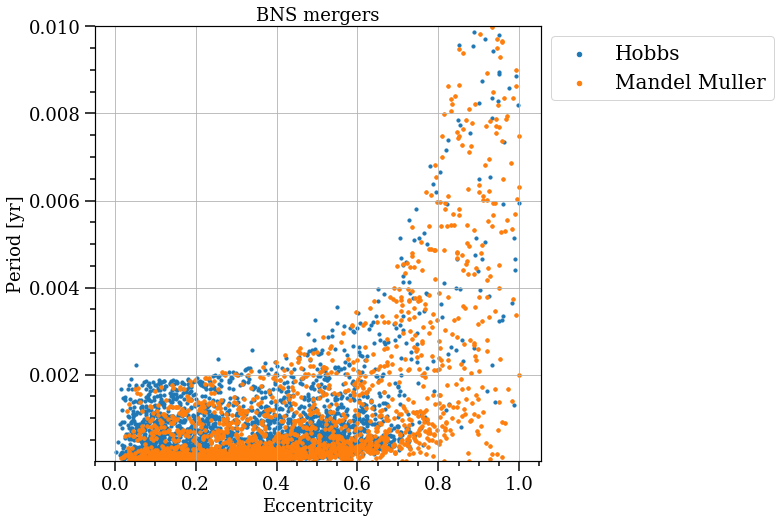

In [67]:
f, ax= plt.subplots(1, 1,  figsize=(8,8)) 

ms=10


layoutAxes(ax=ax, nameX='Eccentricity',\
           nameY='Period [yr]')

plt.scatter(hobbs_ecc, hobbs_period, s=ms, label='Hobbs')
plt.scatter(mm_ecc, mm_period, s=ms, label='Mandel Muller')

plt.title(f"{dco_type} mergers", fontsize=fm)


lgnd = plt.legend(bbox_to_anchor=(1, 1), scatterpoints=1, fontsize=fs)
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
    
# plt.loglog()
# plt.semilogy()
plt.ylim(1e-5, 1e-2)
plt.grid()
plt.show()